In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    child_id: str
    game_id: str
    messages: Annotated[list, add_messages]
    game_description: str
    child_profile: str
    story_analysis: str
    educational_analysis: str 

class BackgroundState(TypedDict):
    child_id: str
    game_id: str
    # TODO LNG: for the inputs below we will test if keeping the list of inputs is useful later. For now go with the simple and promising variant of only having the most recent input in the state.
    game_description: str
    child_profile: str
    story_analysis: str
    educational_analysis: str 

In [5]:
from typing_extensions import Annotated
from langgraph.prebuilt import InjectedState

def get_game_by_id(state: Annotated[State, InjectedState]) -> str:
    '''Return the game description whose ID lives in state['game_id'] 
    :param state: state containing game_id
    :return: description of game
    '''
    game_id = state.get("game_id", "0")
    game = {
        "0": "Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.",
    }.get(game_id, "This is an open world game. You can do anything you want.")
    print("Game loaded:", game)
    return game

def get_child_profile(state: Annotated[State, InjectedState]) -> str:
    '''Return the profile of the child whose ID lives in state['child_id'] 
    :param state: state containing child_id
    :return: profile of child
    '''
    child_id = state.get("child_id", "1")
    child_profile = {
        "1": "Das Kind ist 5 Jahre alt, mag Dinosaurier und Raketen. Es lernt gerade lesen und schreiben.",
        "2": "Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.",
        "3": "Das Kind ist 10 Jahre alt, mag Programmieren und Robotik. Es liest gerne Science-Fiction-Bücher.",
    }.get(child_id, "This is a child with no specific profile.")
    print("Child profile loaded:", child_profile)
    return child_profile

tools = [get_game_by_id, get_child_profile] #  TODO LNG: there shall be a split list to have only the relevant tools for each worker. Remove this "tools" list afterwards. 
### Master chatbot ###
llm = init_chat_model("google_genai:gemini-2.0-flash")
#llm_with_tools = llm.bind_tools([])


E0000 00:00:1760539557.910894  685183 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [26]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.types import Command

def masterChatbot(state: State):
    system_context = f"""
    You are chatting with a child. Your output shall consider the guidance's and be the direct answer to the child.  Try to keep the story engaging and fun. For that if needed even go into a different direction if the educational analysis suggests that the child is bored.
    Use this guidance:
    
    Story Analysis: {state.get('story_analysis', '')}
    Educational Analysis: {state.get('educational_analysis', '')}
    """
    system_message = SystemMessage(content=system_context)
    messages = [system_message] + state["messages"]
    
    return {"messages": state["messages"] + [llm.invoke(messages)]}

educational_prompt = (
        "You are a educational advisor. Analyze the following conversation between an application and a child.\n"
        "Provide analysis of:\n"
        "1. Child's current emotional state\n"
    )

def get_messages_history_from_immediate_graph_state(config) -> list:
    """
    Retrieve the message history from the immediate response graph's state.
    This function assumes that the immediate graph's state is accessible.
    :return: List of messages from the immediate graph's state.
    """
    # Fetch the immediate-thread snapshot
    base_id = config["configurable"]["thread_id"].rsplit("_",1)[0]
    snapshot = background_graph.get_state({"configurable":{"thread_id": base_id}})
    messages = snapshot.values.get("messages", [])
    print(messages)
    return messages

def educationalWorker(state: BackgroundState, config):
    system_message = SystemMessage(content=educational_prompt)
    
    # Analyze the conversation without participating in it
    conversation_summary = "\n".join([
        f"{msg.type}: {msg.content}" for msg in get_messages_history_from_immediate_graph_state(config)
    ])
    child_profile = state.get('child_profile','')
    analysis_message = HumanMessage(
        content=f"Analyze this conversation: {conversation_summary}. Child profile: {child_profile}"
    )
    
    response = llm.invoke([system_message, analysis_message])
    # Store analysis separately from conversation
    return Command(update={"educational_analysis": response.content})


storytelling_prompt = (
        "You are a storytelling advisor. Analyze the following conversation between an application and a child.\n"
        "Provide three next story developments which makes sense to build a fun and engaging story.\n\n"
    )
def storytellingWorker(state: BackgroundState, config):
    system_message = SystemMessage(content=storytelling_prompt)
    
    # Analyze the conversation without participating in it
    conversation_summary = "\n".join([
        f"{msg.type}: {msg.content}" for msg in get_messages_history_from_immediate_graph_state(config)
    ])
    child_profile = state.get('child_profile','')
    game_description = state.get('game_description','')
    analysis_message = HumanMessage(
        content=f"Analyze this conversation: {conversation_summary} Child profile: {child_profile} Game description: {game_description}"
    )
    
    response = llm.invoke([system_message, analysis_message])
    # Store analysis separately from conversation
    return Command(update={"story_analysis": response.content})


def format_response(state: State) -> dict:
    """
    Formats the response of the agent to make it suitable for TTS. This shall be the last step before returning the response to the user.
    Removes the raw response from state to avoid overloading it.
    :param state: 
    :return: Formatted string of response and removal of raw message.
    """
    raw_response = state["messages"][-1].content
    raw_message_id = state["messages"][-1].id
    
    formatted = llm.invoke([
        SystemMessage(content=(
            "You are a formatting assistant. Format the following text to be suitable "
            "for TTS. Remove all special characters such as emojis and make it easy to read aloud."
        )),
        HumanMessage(content=raw_response)
    ]).content

    # Return both the formatted message and removal of the raw message
    return {
        "messages": [
            RemoveMessage(id=raw_message_id),  # Remove the raw response
            AIMessage(content=formatted)        # Add the formatted response
        ]
    }
    
    
def initialStateLoader(state: State) -> dict:
    """
    Load initial state values such as game description and child profile based on IDs in the state.
    :param state: current state
    :return: updated state with game_description and child_profile
    """
    game_description = get_game_by_id(state)
    child_profile = get_child_profile(state)
    return {
        "game_description": game_description,
        "child_profile": child_profile
    }

def immediate_graph_needs_initial_state(state: State) -> str:
    if not (state.get("game_description") and state.get("child_profile")):
        return "initialStateLoader"
    return ["load_analysis"]

def background_graph_needs_initial_state(state: State) -> str:
    if not (state.get("game_description") and state.get("child_profile")):
        return "initialStateLoader"
    return ["educationalWorker", "storytellingWorker"]

def load_analysis(state: State) -> dict:
    """
    Load analysis results from the background graph's state into the immediate graph's state.
    :return: updated state with analysis results
    """
    # TODO LNG: Make this conditional executed e.g. every third interaction.
    # TODO LNG: Add conditional edge if this node takes to much time.
    bg_thread_id = config["configurable"]["thread_id"] + "_analysis"
    snapshot = background_graph.get_state({
        "configurable": {"thread_id": bg_thread_id}
    })
    analyses = {
        "story_analysis":        snapshot.values.get("story_analysis", ""),
        "educational_analysis":  snapshot.values.get("educational_analysis", "")
    }
    return analyses

def immediate_response_graph():
    builder = StateGraph(State)
    
    builder.add_node(initialStateLoader)
    builder.add_node(load_analysis)
    builder.add_node(masterChatbot)
    builder.add_node(format_response)
    
    builder.add_conditional_edges(START, immediate_graph_needs_initial_state)
    builder.add_edge("initialStateLoader", "load_analysis")
    builder.add_edge("load_analysis", "masterChatbot")
    builder.add_edge("masterChatbot", "format_response")
    builder.add_edge("format_response", END)
    
    return builder.compile(checkpointer=memory)



def background_analysis_graph():
    builder = StateGraph(BackgroundState)
    
    builder.add_node(initialStateLoader) 
    builder.add_node(educationalWorker)
    builder.add_node(storytellingWorker)
    
    builder.add_conditional_edges(START, background_graph_needs_initial_state)
    builder.add_edge("initialStateLoader", "educationalWorker")
    builder.add_edge("initialStateLoader", "storytellingWorker")
    builder.add_edge("educationalWorker", END)
    builder.add_edge("storytellingWorker", END)
    
    return builder.compile(checkpointer=memory)

immediate_graph = immediate_response_graph()
background_graph = background_analysis_graph()



---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	initialStateLoader(initialStateLoader)
	load_analysis(load_analysis)
	masterChatbot(masterChatbot)
	format_response(format_response)
	__end__(<p>__end__</p>)
	__start__ -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	initialStateLoader(initialStateLoader)
	educationalWorker(educationalWorker)
	storytellingWorker(storytellingWorker)
	__end__(<p>__end__</p>)
	__start__ -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



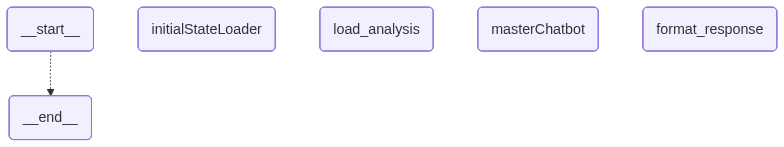

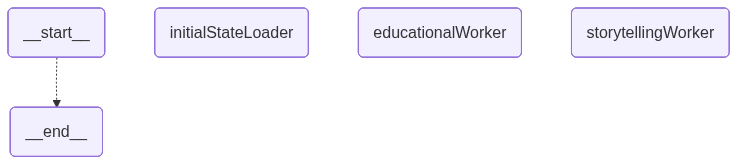

In [18]:
print(immediate_graph.get_graph().draw_mermaid())
print(background_graph.get_graph().draw_mermaid())

from IPython.display import Image, display

display(Image(immediate_graph.get_graph().draw_mermaid_png()))
display(Image(background_graph.get_graph().draw_mermaid_png()))

In [8]:
# Simulation of first interaction
config  = {'configurable': { 'thread_id': '9'}}
#state = graph.invoke({"messages": [{"role": "user", "content": "Hi how are you?"}]}, config=config)
state = immediate_graph.invoke({"messages": [
    {"role": "user", "content": "Start"}
],
    "child_id": "2",
    "game_id": "0",
}, config=config)
print("======== Final response ========")
print(state["messages"][-1].content)

Task __start__ with path ('__pregel_pull', '__start__') wrote to unknown channel branch:to:{'story_analysis': '', 'educational_analysis': ''}, ignoring it.


Game loaded: Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.
Child profile loaded: Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.
======== Final response ========
Hey there, future adventurer. Ready for a super fun story time?


In [9]:
import asyncio

async def process_user_input(user_input, config):
    # Sofortiger Response-Graph
    immediate_graph = immediate_response_graph()
    
    # Background-Analysis-Graph  
    background_graph = background_analysis_graph()
    
    immediate_task = asyncio.create_task(
        immediate_graph.ainvoke(user_input, config)
    )
    
    
    # Wait for the immediate response
    immediate_result = await immediate_task
    
    # Start the background analysis after the immediate response to have the immediate_graph state of ready.
    background_input = {
        "child_profile": immediate_result["child_profile"],
        "game_description" : immediate_result["game_description"],
        "messages": immediate_result["messages"],
    }
    background_config = {
        "configurable": {
            "thread_id": config["configurable"]["thread_id"] + "_analysis"
        }
    }
    background_task = asyncio.create_task(
       background_graph.ainvoke(background_input, background_config)
    )
    
    # Background task läuft weiter (Fire & Forget)
    # Keine await - läuft im Hintergrund weiter
    
    return immediate_result



    

In [27]:

config = {'configurable': {'thread_id': '9'}}
in_message = input("You: ")
import asyncio

try:
    result = await process_user_input({"messages": [{"role": "user", "content": in_message}]}, config)
except SyntaxError:
    result = asyncio.run(process_user_input({"messages": [{"role": "user", "content": in_message}]}, config))


print(result["messages"][-1].content)

The wizard stroked his beard thoughtfully. "Hmm, a confession and an apology... Interesting. Tell you what, Sparky. I'm not going to get angry. Instead, we're going to play a game! A Forgiveness Game! Think of it like a video game, but instead of a controller, we use... well, our actions! Level one: Hat Retrieval, you already completed it! Level two: Potion Delivery! I need some rare moonpetal flowers from the Whispering Woods. Think you can help me find them before nightfall? It's a race against the clock!"
